In [1]:
# Import the necissary modules
import numpy as np
import obspy
from obspy import Stream
import subprocess as sp
from wipy.wipy_utils import utils
import matplotlib
from matplotlib import pyplot as plt
import scipy
from copy import deepcopy

In [2]:
# Create a List of paths for the fieled data files
data_folder = "Field-Data/Acceleration-Data/BW_Line2320_Inline/"
gahter_names = "Ux_file_single_d.su"

p = sp.run(
    ["ls", data_folder],
    capture_output=True,
    text=True
    )

paths = p.stdout.split("\n")
paths = paths[:-1]  # get rid of empty element at the end of the paths list
print(paths)

['H_S_2320.0_0.0_1_1216.segy', 'H_S_2320.0_0.0_2_1217.segy', 'H_S_2320.0_0.0_3_1219.segy', 'H_S_2320.0_0.0_4_1220.segy', 'H_S_2320.0_0.0_5_1218.segy', 'H_S_2320.0_100.0_1_1337.segy', 'H_S_2320.0_100.0_2_1333.segy', 'H_S_2320.0_100.0_3_1334.segy', 'H_S_2320.0_100.0_4_1335.segy', 'H_S_2320.0_100.0_5_1336.segy', 'H_S_2320.0_10.0_1_1230.segy', 'H_S_2320.0_10.0_2_1227.segy', 'H_S_2320.0_10.0_3_1228.segy', 'H_S_2320.0_10.0_4_1229.segy', 'H_S_2320.0_105.0_1_1343.segy', 'H_S_2320.0_105.0_2_1339.segy', 'H_S_2320.0_105.0_3_1340.segy', 'H_S_2320.0_105.0_4_1341.segy', 'H_S_2320.0_105.0_5_1342.segy', 'H_S_2320.0_110.0_1_1349.segy', 'H_S_2320.0_110.0_2_1345.segy', 'H_S_2320.0_110.0_3_1346.segy', 'H_S_2320.0_110.0_4_1347.segy', 'H_S_2320.0_110.0_5_1348.segy', 'H_S_2320.0_115.0_1_1355.segy', 'H_S_2320.0_115.0_2_1351.segy', 'H_S_2320.0_115.0_3_1352.segy', 'H_S_2320.0_115.0_4_1353.segy', 'H_S_2320.0_115.0_5_1354.segy', 'H_S_2320.0_120.0_1_1363.segy', 'H_S_2320.0_120.0_2_1358.segy', 'H_S_2320.0_120.0_3_1

In [3]:
# pull out the shot locations in accourdance to how Sean Beamis named the files
shot_locs = []
for path in paths:

    shot_loc = path.split("_")[3]
    shot_locs.append(float(shot_loc))

In [4]:
def stack_data(data_folder, paths, shot_locs, s_x):

    # initialize data
    data = obspy.read(data_folder + paths[0], format="segy")

    for trace in data:
        trace.data *= 0.0

    Nt = len(data[0].data)
    dt = data.traces[0].stats.delta

    # stack the data
    for i in range(len(shot_locs)):
        
        if shot_locs[i] == s_x:
            data_sub = obspy.read(data_folder + paths[i], format="segy")
            
            for j in range(len(data)):
                data[j].data += data_sub[j].data

    return Nt, dt, data


In [5]:
Nt, dt, data = stack_data(data_folder, paths, shot_locs, 0.0)

Text(0.5, 1.0, 'Acceleration Data')

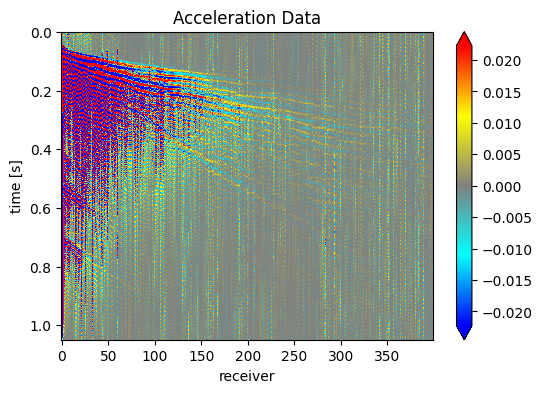

In [6]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
    ["blue", "cyan", "gray", "yellow", "red"])

fig, ax = utils.plot_image(data, 0.001, cmap=cmap)
ax.invert_yaxis()
ax.set_title("Acceleration Data")

(0.0, 80.0)

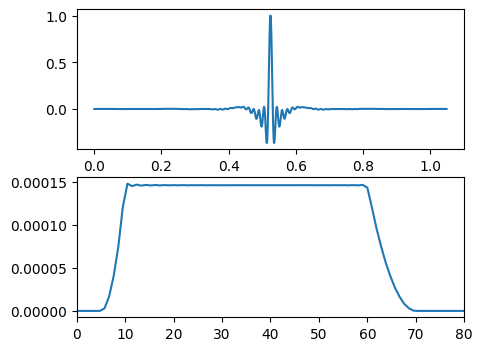

In [7]:
T = np.arange(0, Nt*dt, dt)

# ormsby stf
orms_func = lambda t, t0, f0, f1, f2, f3: \
    ((f0**2)/(f1-f0))*(np.sinc(f0*(t-t0))**2) - \
    ((f1**2)/(f1-f0))*(np.sinc(f1*(t-t0))**2) - \
    ((f2**2)/(f3-f2))*(np.sinc(f2*(t-t0))**2) + \
    ((f3**2)/(f3-f2))*(np.sinc(f3*(t-t0))**2)
f0 = 5
f1 = 10
f2 = 60
f3 = 70
t0 = np.max(T)/2
orms = orms_func(T, t0, f0, f1, f2, f3)
orms /= np.max(np.abs(orms))

freq, P = scipy.signal.periodogram(orms, 1/dt)

fig, ax = plt.subplots(2, 1, figsize=(5,4))
ax[0].plot(T, orms)
ax[1].plot(freq, P)
ax[1].set_xlim(0, 80)

In [8]:
def integrate_data(data, filt):

    for i in range(2):
        for trace in data:
            trace.data = np.cumsum(np.convolve(trace.data, filt, "same"))
            trace.data = np.convolve(trace.data, filt, "same")

    return data


In [9]:
data = integrate_data(data, orms)

Text(0.5, 1.0, 'Displacement Data')

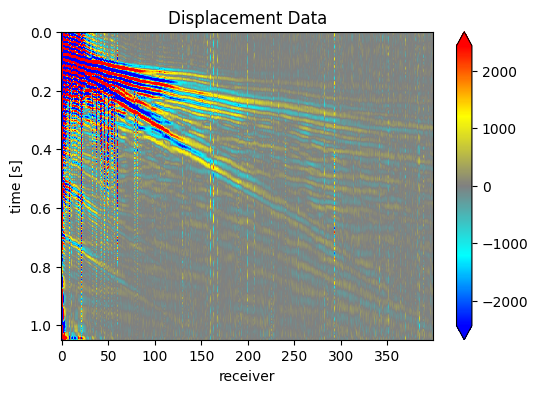

In [10]:
fig, ax = utils.plot_image(data, 0.001, cmap=cmap)
ax.invert_yaxis()
ax.set_title("Displacement Data")

In [11]:
def interpolate_data(temp, data, T):

    Nt_interp = len(temp[0].data)
    dt_interp = temp.traces[0].stats.delta
    T_interp = np.arange(0, Nt_interp*dt_interp, dt_interp)

    final = deepcopy(temp)

    for i in range(len(final)):
        f = scipy.interpolate.interp1d(T, data[i].data, "linear")
        final[i].data = f(T_interp)
        final[i].data = np.float32(final[i].data)

    return final

In [12]:
SU_template_path = "test_data/000000/Ux_file_single_d.su" 

temp = obspy.read(SU_template_path, format="SU")

final = interpolate_data(temp, data, T)


Text(0.5, 1.0, 'Displacement Data')

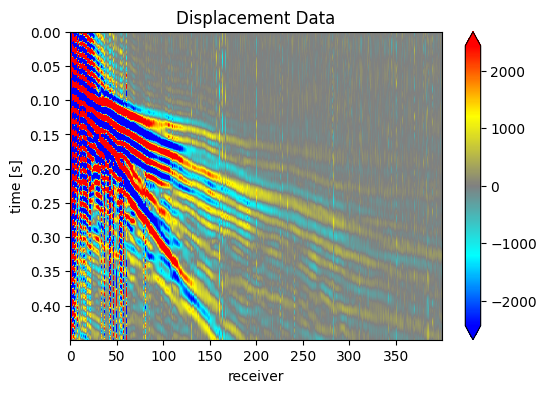

In [13]:
fig, ax = utils.plot_image(final, 0.001, cmap=cmap)
ax.invert_yaxis()
ax.set_title("Displacement Data")

In [14]:
out_folder = "Field-Data/Displacement-Data"

s_x = np.arange(0,205,5) 

for i in range(len(s_x)):

    # stack the acceleration data 
    Nt, dt, data = stack_data(data_folder, paths, shot_locs, s_x[i])
    T = np.arange(0, Nt*dt, dt)

    # integrate the displacment data
    data = integrate_data(data, orms)

    # load template data   
    SU_template_path = "test_data/{:06d}/".format(i) + gahter_names
    temp = obspy.read(SU_template_path, format="SU")

    # interpolate data
    final = interpolate_data(temp, data, T)

    # write the displacement data
    out_path = out_folder + "/{:06d}/".format(i) + gahter_names
    final.write(out_path, format="SU")


(<Figure size 600x400 with 2 Axes>,
 <Axes: xlabel='receiver', ylabel='time [s]'>)

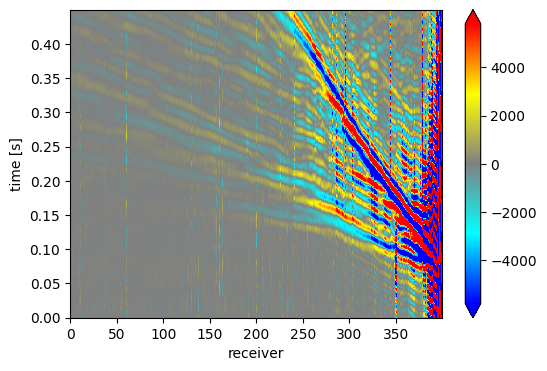

In [15]:

check = obspy.read(out_path, format="SU")
utils.plot_image(check, clip=0.001, cmap=cmap)